In [ ]:
# pip install factor_analyzer
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# conda install -c conda-forge scikit-learn-extra

In [86]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

## Dataset Creation
The primary dataframe we will be working with is df_fct, which is a dataframe composed of only the 36 factor variables.

In [216]:
# Create dataframe from customer_data file
df = pd.read_csv('customer_data.csv')

# Create dataframe of factors only
df_fct =  df.drop(['UID','Const'], axis=1)

# Number of variables/factors/stimuli
variables_to_examine = len(df_fct.columns)

## Factor Analysis

The variables are all on a similar scale, so we will use the covariance matrix for identifying principal components.

In [217]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=variables_to_examine, rotation=None)
fa.fit(df_fct)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()

# Create FactorAnalyzer object
rotation = 'varimax'
n_factors = sum(i >= 1 for i in ev)
fa = FactorAnalyzer(n_factors=n_factors, rotation=rotation)

# Fit factor analysis model to variables
fa.fit(df_fct)

# The loadings are the coefficients that make up the linear combination of original variables to get the factors (v1 = l1x1 + l2X2)
loadings = fa.loadings_

# Create dataframe of eigenvalues of the covariance matrix

data = {'factor'                    : range(1,n_factors+1),
        'eigenvalues'               : fa.get_eigenvalues()[0][0:n_factors],
        'common_factor_eigenvalues' : fa.get_eigenvalues()[1][0:n_factors],
        'variance'                  : fa.get_factor_variance()[0],
        'proportional_variance'     : fa.get_factor_variance()[1],
        'cumulative_variance'       : fa.get_factor_variance()[2]
       }

cov_matrix_eigenvals = pd.DataFrame(data=data).set_index('factor')

# Scores for the factor analysis, converted to dataframe
scores = pd.DataFrame(fa.transform(df_fct))

### Clustering

In [218]:
sw=[]

for i in range(2,7):
    
    # Create clustering objects
    cls1 = KMeans(n_clusters=i, random_state=0)
    cls2 = KMedoids(n_clusters=i, random_state=0)
    cls3 = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage ='ward') #if linkage is ward, affinity must be Euclidean
    cls_algs = [['kMeans', cls1], ['kMedoids', cls2], ['Hierarchical', cls3]]
    
    # Fit and score clustering solutions for i clusters with each clustering algorithm
    for cls in cls_algs:
        
        # A place to keep clustering solution info
        i_stats = []
        
        # Fit the model to the factor analysis scores
        cls[1].fit(scores)
        
        # List of assigned clusters
        clusters = cls[1].fit_predict(scores)
        
        # Silhouette scores for each solution
        silhouette_avg = silhouette_score(scores,clusters)
        
        # Store solution info
        algorithm = cls[0]
        i_stats.append(algorithm)
        i_stats.append(i)
        i_stats.append(silhouette_avg)
        i_stats.append(clusters)
        sw.append(i_stats)
        
        # Add columns of cluster assignments to df_fct datafram
        df_fct[algorithm+'_'+'cluster'+'_'+str(i)] = clusters


# Reorder cluster lists by descending silhouette scores.  Clusters in first element should be assigned to training data.
sw = sorted(sw, key=itemgetter(2), reverse=True)

# Add the labels to the training dataset (you can ignore the warning when the cell runs)
df_fct['cluster'] = sw[0][3]

### Classification

#### Split into training, validation, and test data

In [168]:
# These are the variable columns and the optimal cluster assignment
data_of_interest = df_fct.iloc[:,np.r_[:variables_to_examine,-1]]

# Changes dataset into 0s and 1s depending on the value of the cell
# data_of_interest = data_of_interest.mask(data_of_interest > 0, 1).mask(data_of_interest <= 0, 0)

# Split data into 75% training, 12.5% validation, 12.5% test
train, valid = train_test_split(data_of_interest, test_size=0.25, random_state=123)

valid, test = train_test_split(valid, test_size=0.5, random_state=123)

# X is unlabeled training data, y is true training labels 
X, y = train.loc[:, train.columns != 'cluster'], train['cluster']

X_valid, y_valid = valid.loc[:, train.columns != 'cluster'], valid['cluster']

X_test, y_test = test.loc[:, test.columns != 'cluster'], test['cluster']

#### Classifier Loop

In [183]:
clf_scores = []

clf1 = RandomForestClassifier(random_state=0)
clf2 = GradientBoostingClassifier(random_state=0)
clf3 = SVC(random_state=0)
clf4 = KNeighborsClassifier()

classifiers = [['random_forest', clf1], ['gradient boosted trees', clf2], ['SVC', clf3], ['KNN', clf4]]

for classifier in classifiers:
    
    # Fit classifier to training data
    classifier[1].fit(X,y)
    
    # Store classifier-specific results
    results = []
    results.append(classifier[0])
    results.append(classifier[1].score(X_valid,y_valid))

    # Overall classifier results
    clf_scores.append(results)

# Sort classifier accuracy in descending order
clf_scores = sorted(clf_scores, key=itemgetter(1), reverse=True)    
    
clf_scores

[['SVC', 0.9056603773584906],
 ['random_forest', 0.8679245283018868],
 ['gradient boosted trees', 0.8490566037735849],
 ['KNN', 0.8490566037735849]]

In [193]:
# I don't think the necessarily needs to be in the final product, but it helps evaluate the models.

from sklearn.metrics import classification_report

valid_pred = clf3.predict(X_valid)

print(classification_report(y_valid, valid_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.75      0.82      0.78        11

    accuracy                           0.91        53
   macro avg       0.85      0.87      0.86        53
weighted avg       0.91      0.91      0.91        53



##### View feature importance

In [ ]:
importance = pd.DataFrame(clf.feature_importances_)

importance['variable'] = list(range(1,37))

importance.set_index('variable', inplace=True)

importance = importance.sort_values(by=0, ascending=False)

importance['difference'] = importance[0] - importance[0].shift(-1)
print(importance)

<AxesSubplot:xlabel='variable'>

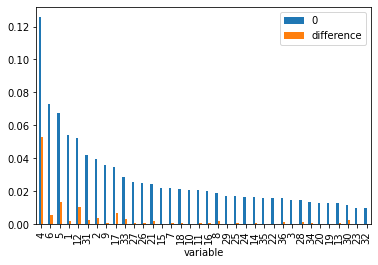

In [174]:
importance.plot(kind='bar')